# Pupil position and diameter
Is pupil position modulated by stimulus, choice, bias?

In [4]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from one.api import ONE

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from video_functions import  get_dlc_XYs, get_raw_and_smooth_position, get_pupil_diameter, stack_pupil, pupil_center

one = ONE(mode='remote')


In [5]:
def prepro(trials):

    """ Performance """
    # Some preprocessing
    trials['contrastLeft'] = trials['contrastLeft'].fillna(0)
    trials['contrastRight'] = trials['contrastRight'].fillna(0)
    trials['signed_contrast'] = - trials['contrastLeft'] + trials['contrastRight']
    trials['contrast'] = trials['contrastLeft'] + trials['contrastRight']
    trials['correct_easy'] = trials['feedbackType']
    trials.loc[trials['correct_easy']==-1, 'correct_easy'] = 0
    trials['correct'] = trials['feedbackType']
    trials.loc[trials['contrast']<.5, 'correct_easy'] = np.nan
    trials.loc[trials['correct']==-1, 'correct'] = 0

    """ Response/ reaction times """
    trials['response'] = trials['response_times'] - trials['goCue_times']
    trials['reaction'] = trials['firstMovement_times'] - trials['goCue_times']
    """ Quiescence elongation """
    trials['elongation'] = trials['goCue_times'] - trials['quiescencePeriod'] - trials['intervals_0']
    """ Win stay lose shift """
    trials['prev_choice'] = trials['choice'] * np.nan
    trials['prev_choice'][1:] = trials['choice'][:-1]
    trials['prev_feedback'] = trials['feedbackType'] * np.nan
    trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
    trials['wsls'] = trials['choice'] * np.nan
    trials.loc[(trials['prev_feedback']==1.) & (trials['choice']==trials['prev_choice']), 'wsls'] = 'wst'
    trials.loc[(trials['prev_feedback']==1.) & (trials['choice']!=trials['prev_choice']), 'wsls'] = 'wsh'
    trials.loc[(trials['prev_feedback']==-1.) & (trials['choice']!=trials['prev_choice']), 'wsls'] = 'lsh'
    trials.loc[(trials['prev_feedback']==-1.) & (trials['choice']==trials['prev_choice']), 'wsls'] = 'ls'

    return trials

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS020/2020-02-07/001/alf/#2023-04-20#/_ibl_leftCamera.times.64f65cfb-fb1b-49b2-9cd1-0b773a64373a.npy Bytes: 2145968


100%|██████████| 2.0465545654296875/2.0465545654296875 [00:01<00:00,  1.81it/s]
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:452: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:453: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
local md5 mismatch on dataset: cortexlab/Subjects/KS020/2020-02-07/001/alf/_ibl_trials.goCueTrigger_times.npy


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS020/2020-02-07/001/alf/#2024-07-15#/_ibl_trials.stimOnTrigger_times.e31e7884-eb2b-4f1b-bc92-16c984e79783.npy Bytes: 2840


100%|██████████| 0.00270843505859375/0.00270843505859375 [00:00<00:00,  1.20s/it]


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS020/2020-02-07/001/alf/#2024-07-15#/_ibl_trials.stimOff_times.fc257215-fa3c-4d37-80f6-0f013e637402.npy Bytes: 2840Downloading: /Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS020/2020-02-07/001/alf/_ibl_trials.goCueTrigger_times.304738a6-9753-4607-8110-d9e3fa2adfde.npy Bytes: 2840
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS020/2020-02-07/001/alf/#2024-07-15#/_ibl_trials.stimOffTrigger_times.a78024a9-83d0-4aec-94f5-4726783b80bd.npy Bytes: 2840



  0%|          | 0/0.00270843505859375 [00:00<?, ?it/s]
100%|██████████| 0.00270843505859375/0.00270843505859375 [00:00<00:00,  5.36s/it]
100%|██████████| 0.00270843505859375/0.00270843505859375 [00:00<00:00,  4.49s/it]
100%|██████████| 0.00270843505859375/0.00270843505859375 [00:00<00:00,  2.68s/it]


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS020/2020-02-07/001/alf/#2024-07-15#/_ibl_trials.table.92a4072b-3c6a-45fa-8c82-41701bdf1b66.pqt Bytes: 32369


100%|██████████| 0.030869483947753906/0.030869483947753906 [00:00<00:00,  5.25s/it]


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

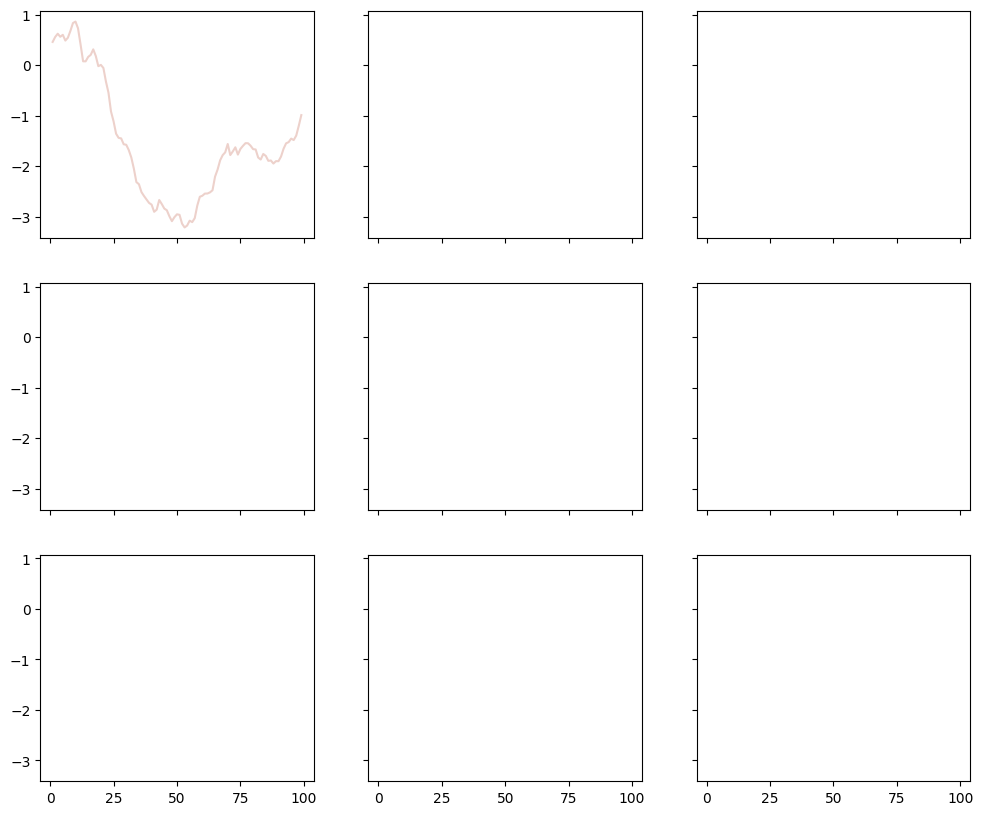

In [7]:

# Parameters 
eid = '572a95d1-39ca-42e1-8424-5c9ffcb2df87'  # Example session
video_type = 'left'
ephys=True
t_init = 0.5
t_end = 2

# Pupil data
x_raw_data, x_smooth_data, y_raw_data, y_smooth_data = get_raw_and_smooth_position(one, eid, video_type, ephys, pupil_center)
x_raw_diam, x_smooth_diam, _, _ = get_raw_and_smooth_position(one, eid, video_type, ephys, get_pupil_diameter)

times, XYs = get_dlc_XYs(one, eid, video_type)

# Trials data
trials_mouse = one.load_object(eid, obj='trials', namespace='ibl')
trials_df = trials_mouse.to_df()
processed_trials = prepro(trials_df)


to_plot = [x_smooth_data, y_smooth_data, x_smooth_diam]
label = ['Pupil X position', 'Pupil y position', 'Pupil diameter']
events = ['stimOn_times', 'firstMovement_times', 'feedback_times']
event_label = ['Stimulus onset', 'Movement onset', 'Feedback time']

fig, ax = plt.subplots(nrows=3 , ncols=3, sharex=True, sharey=True, figsize=[12, 10])

for p, pos in enumerate(to_plot):

       position = pos
       time = times[0:len(position)]
       trials = trials_df
       trials = processed_trials
       for ev, event in enumerate(events):
              stacked_pupil, stack_time = stack_pupil(position, time, trials, event, t_init, t_end)

              pupil_stack = pd.DataFrame(stacked_pupil[:,0:100])
              pupil_stack['feedback'] = list(processed_trials['correct'])
              pupil_stack['choice'] = list(processed_trials['choice'])
              pupil_stack['contrast'] = list(processed_trials['contrast'])
              pupil_stack['side'] = list(np.sign(processed_trials['signed_contrast']))

              melted = pd.melt(pupil_stack, id_vars=['feedback', 'choice', 'contrast', 'side'], value_vars=np.array(pupil_stack.keys()[1:-4]))
              correct_data = melted.loc[(melted['contrast']>0) & (melted['contrast']<=1) & (melted['feedback']==1)]
              incorrect_data = melted.loc[(melted['contrast']>0) & (melted['contrast']<=1) & (melted['feedback']==0)]
              use_data = melted.loc[(melted['contrast']>0) & (melted['contrast']<=1)]
              plt.rc('font', size=12)
              if ev == 2 & p == 2:
                     sns.lineplot(x='variable', y='value', hue='side',style='feedback', data=use_data, ax=ax[p, ev])  #  style='feedback',
              else:
                     sns.lineplot(x='variable', y='value', hue='side',style='feedback', data=use_data, ax=ax[p, ev], legend=None)  #  style='feedback',
              ax[p, ev].vlines(30, -15, 15, linestyles='dashed', color='Gray')
              ax[p, ev].set_xlabel(str('Time from '+ event_label[ev] +' (ms)'))
              ax[p, ev].set_ylabel(label[p])
              ax[p, ev].set_xticks([0, 30, 60, 90], [-500, 0, 500, 1000],
                     rotation=20)
              ax[p, ev].set_xlim([0, 95])
              ax[p, ev].legend()
              # plt.title(eid)

plt.tight_layout()
plt.show()
